In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import np_utils
from skimage.color import gray2rgb, rgb2gray, label2rgb

In [2]:
# get dataset and split it into two datasets (training, testing)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

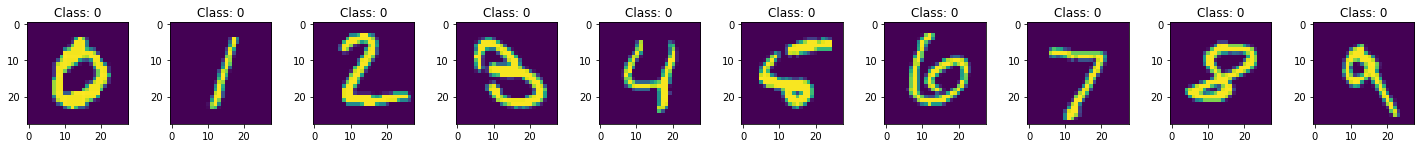

In [29]:
numbers = []
for i in range(10):
    indexes = np.where(y_test == i)
    all_indexes = np.hstack(indexes)
    numbers.append(all_indexes[0])

# show images (P = predicted class, R = Real class)
fig, axes = plt.subplots(1, 10, figsize=(20, 3))
fig.tight_layout()

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[numbers][i])
    ax.title.set_text(f'Class: {np.argmax(y_test[i])}')

In [ ]:
def preprocess_data(x, y, limit):
    indexes = []
    n = 10
    
    for i in range(n):
        indexes.append(np.where(y == i)[0][:limit])

    all_indexes = np.hstack(indexes)
    all_indexes = np.random.permutation(all_indexes)
    x, y = x[all_indexes], y[all_indexes]
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype("float32") / 255
    y = np_utils.to_categorical(y)
    y = y.reshape(len(y), n, 1)
    return x, y

In [ ]:

# # preprocessing the data
# X_train, y_train = preprocess_data(X_train, y_train, 100)
# X_test, y_test = preprocess_data(X_test, y_test, 20)

# # set of images
# images = X_test.copy()

In [ ]:

# # preprocessing the data
# X_train, y_train = preprocess_data(X_train, y_train, 100)
# X_test, y_test = preprocess_data(X_test, y_test, 20)

# # set of images
# images = X_test.copy()

In [ ]:
# show images (P = predicted class, R = Real class)
fig, axes = plt.subplots(1, 10, figsize=(20, 3))
fig.tight_layout()
for i,ax in enumerate(axes.flat):
    ax.imshow(images[i, 0])
    ax.title.set_text(f'Class: {np.argmax(y_test[i])}')